In [1]:
# INFO 7390 Final Project
# NYC Airbnb Open Data 2020
# http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/visualisations/listings.csv

# Tasks:
# Data clusting
# Airbnb Price Prediction

# Columns:
# id - Listing ID
# name - Listing Title
# host_id - ID of Host
# host_name - Name of Host
# neighbourhood_group - Borough that contains listing
# neighbourhood - Name of neighbourhood that listing is in
# latitude - latitude of listing
# longitude - longitude of listing
# room_type - Type of public space that is being offered
# price - price per night, USD
# minimum_nights - minimum number of nights required to book listing
# number_of_reviews - total number of reviews that listing has accumulated
# last_review - date in which listing was last rented
# reviews_per_month - total number of reviews divided by the number of months the listing is active
# calculated_host_listings_count - amount of listing per host**
# availability_365 - number of days per year the listing is active


# Import Libaray and Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
df=pd.read_csv('./listings.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,175,3,48,2019-11-04,0.36,2,365
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,76,1,354,2020-09-20,4.82,1,2
2,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,29,50,2019-12-02,0.36,1,2
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66120,-73.99423,Entire home/apt,175,7,1,2014-01-02,0.01,1,359
4,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,73,2,473,2020-03-15,3.40,1,350


# Drop null value

In [4]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            17
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10517
reviews_per_month                 10517
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
df.drop(['name','id','host_name','last_review'], axis=1, inplace=True)
df['reviews_per_month'].fillna(0, inplace=True)

In [6]:
df.iloc[:,3:].describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000
mean,40.729714,-73.950756,150.104330,9.301191,22.456992,0.660568,6.668338,105.422447
std,0.055180,0.047505,323.366768,24.232548,46.664551,1.167009,24.854672,139.519399
min,40.508680,-74.239860,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.689880,-73.982980,64.000000,2.000000,1.000000,0.020000,1.000000,0.000000
50%,40.724560,-73.955285,100.000000,3.000000,4.000000,0.170000,1.000000,1.000000
75%,40.763350,-73.933980,160.000000,7.000000,20.000000,0.800000,2.000000,189.000000
max,40.911690,-73.711930,10000.000000,1250.000000,746.000000,41.370000,239.000000,365.000000


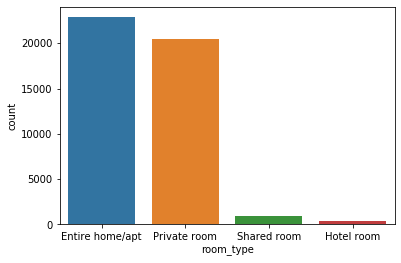

In [7]:
ax = sns.countplot(x="room_type", data=df)

In [8]:
rt_price = df.groupby("room_type")["price"].mean()
rt_price

room_type
Entire home/apt    201.320954
Hotel room         311.175258
Private room        91.800956
Shared room        108.577174
Name: price, dtype: float64

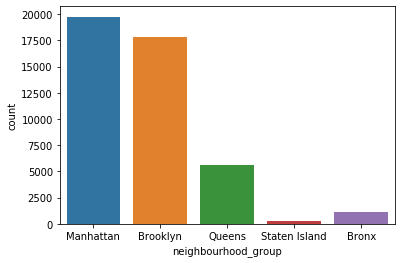

In [9]:
ax = sns.countplot(x="neighbourhood_group", data=df)

# Encoding categorical variables

In [10]:
feature_columns=['neighbourhood_group','room_type','price','minimum_nights','calculated_host_listings_count','availability_365']
df2=df[feature_columns]
df2.head()

,neighbourhood_group,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,Manhattan,Entire home/apt,175,3,2,365
1,Brooklyn,Entire home/apt,76,1,1,2
2,Brooklyn,Private room,60,29,1,2
3,Brooklyn,Entire home/apt,175,7,1,359
4,Manhattan,Private room,73,2,1,350


In [11]:
df2['room_type']=df2['room_type'].factorize()[0]
df2['neighbourhood_group']=df2['neighbourhood_group'].factorize()[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df2.head()

,neighbourhood_group,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,0,0,175,3,2,365
1,1,0,76,1,1,2
2,1,1,60,29,1,2
3,1,0,175,7,1,359
4,0,1,73,2,1,350


# Train Test Split

In [13]:
y = df2['price']
x= df2.drop(['price'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=66)

# Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


model = LinearRegression()
model.fit(x_train,y_train)
y_pred=(model.predict(x_test))

print('R-squared train score: {:.3f}'.format(model.score(x_train, y_train)))
print('R-squared test score: {:.3f}'.format(model.score(x_test, y_test)))
print('MAE:{:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print('MSE:{:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared train score: 0.027
R-squared test score: 0.029
MAE:88.132
MSE:86466.160
RMSE:294.051


In [20]:
error=pd.DataFrame(np.array(y_test).flatten(),columns=['actual'])
error['prediction']=np.array(y_pred)
error.head(20)

,actual,prediction
0,60,169.092256
1,169,202.630308
2,190,211.745061
3,55,-1.847615
4,75,100.182040
5,80,65.009160
6,261,202.742106
7,300,167.345630
8,80,135.802113
9,68,191.225478


# ML Algorithm1: NLP

# ML Algorithm2: Random Forest